Perform distribution-agnostic univariate statistical profiling on Aadhaar biometric, demographic, and enrollment datasets to identify baseline behavior, long-tailed variables, and early anomaly signals.

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats


In [6]:
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
INTERMEDIATE_PATH = PROJECT_ROOT / "data" / "intermediate"

biometric_df = pd.read_parquet(INTERMEDIATE_PATH / "biometric_base.parquet")
demographic_df = pd.read_parquet(INTERMEDIATE_PATH / "demographic_base.parquet")
enrollment_df = pd.read_parquet(INTERMEDIATE_PATH / "enrollment_base.parquet")

biometric_df.shape, demographic_df.shape, enrollment_df.shape


((1861108, 7), (1571700, 7), (1006029, 8))

In [7]:
print("biometric:--\n", biometric_df.dtypes)
print("demographic:--\n",demographic_df.dtypes)
print("enrollment:--\n",enrollment_df.dtypes)


biometric:--
 date            object
state           object
district        object
pincode          int64
bio_age_5_17     int64
bio_age_17_      int64
source_file     object
dtype: object
demographic:--
 date             object
state            object
district         object
pincode           int64
demo_age_5_17     int64
demo_age_17_      int64
source_file      object
dtype: object
enrollment:--
 date              object
state             object
district          object
pincode            int64
age_0_5            int64
age_5_17           int64
age_18_greater     int64
source_file       object
dtype: object


In [8]:
COLUMN_ROLES = {}
COLUMN_ROLES["biometric"] = {
    "identifier": [],  # no row-level IDs present
    
    "numeric_signal": [
        "bio_age_5_17",
        "bio_age_17_"
    ],
    
    "categorical_attribute": [
        "state",
        "district",
        "pincode"
    ],
    
    "timestamp": [
        "date"
    ],
    
    "metadata": [
        "source_file"
    ]
}

COLUMN_ROLES["demographic"] = {
    "identifier": [],
    
    "numeric_signal": [
        "demo_age_5_17",
        "demo_age_17_"
    ],
    
    "categorical_attribute": [
        "state",
        "district",
        "pincode"
    ],
    
    "timestamp": [
        "date"
    ],
    
    "metadata": [
        "source_file"
    ]
}
COLUMN_ROLES["enrollment"] = {
    "identifier": [],
    
    "numeric_signal": [
        "age_0_5",
        "age_5_17",
        "age_18_greater"
    ],
    
    "categorical_attribute": [
        "state",
        "district",
        "pincode"
    ],
    
    "timestamp": [
        "date"
    ],
    
    "metadata": [
        "source_file"
    ]
}



In [9]:
def univariate_profile(df: pd.DataFrame, numeric_cols: list) -> pd.DataFrame:
    profiles = []
    
    for col in numeric_cols:
        series = df[col].dropna()
        
        profiles.append({
            "column": col,
            "count": series.count(),
            "mean": series.mean(),
            "median": series.median(),
            "std": series.std(),
            "min": series.min(),
            "p1": series.quantile(0.01),
            "p5": series.quantile(0.05),
            "p25": series.quantile(0.25),
            "p75": series.quantile(0.75),
            "p95": series.quantile(0.95),
            "p99": series.quantile(0.99),
            "max": series.max(),
            "skewness": stats.skew(series),
            "kurtosis": stats.kurtosis(series)
        })
        
    return pd.DataFrame(profiles)


In [10]:
biometric_numeric_cols = COLUMN_ROLES["biometric"]["numeric_signal"]

biometric_univariate = univariate_profile(
    biometric_df, biometric_numeric_cols
)

biometric_univariate.sort_values("p99", ascending=False).head(10)


,column,count,mean,median,std,min,p1,p5,p25,p75,p95,p99,max,skewness,kurtosis
1,bio_age_17_,1861108,19.094131,4.0,88.065018,0,0.0,0.0,1.0,10.0,62.0,324.0,7625,18.078174,609.141447
0,bio_age_5_17,1861108,18.390580,3.0,83.704209,0,0.0,0.0,1.0,11.0,61.0,298.0,8002,19.330611,709.517859


In [11]:
demographic_numeric_cols = COLUMN_ROLES["demographic"]["numeric_signal"]

demographic_univariate = univariate_profile(
    demographic_df, demographic_numeric_cols
)

demographic_univariate.sort_values("p99", ascending=False).head(10)


,column,count,mean,median,std,min,p1,p5,p25,p75,p95,p99,max,skewness,kurtosis
1,demo_age_17_,1571700,20.089502,6.0,112.401859,0,0.0,1.0,2.0,15.0,59.0,198.0,16166,37.281555,2641.315892
0,demo_age_5_17,1571700,2.179481,1.0,12.987463,0,0.0,0.0,0.0,2.0,7.0,19.0,2690,40.910548,3554.941623


In [12]:
enrollment_numeric_cols = COLUMN_ROLES["enrollment"]["numeric_signal"]

enrollment_univariate = univariate_profile(
    enrollment_df, enrollment_numeric_cols
)

enrollment_univariate.sort_values("p99", ascending=False).head(10)


,column,count,mean,median,std,min,p1,p5,p25,p75,p95,p99,max,skewness,kurtosis
0,age_0_5,1006029,3.525709,2.0,17.538511,0,0.0,0.0,1.0,3.0,10.0,23.0,2688,43.920842,3105.527170
1,age_5_17,1006029,1.710074,0.0,14.369625,0,0.0,0.0,0.0,1.0,6.0,14.0,1812,41.899946,2477.037809
2,age_18_greater,1006029,0.167344,0.0,3.220525,0,0.0,0.0,0.0,0.0,0.0,2.0,855,87.854563,12918.492873


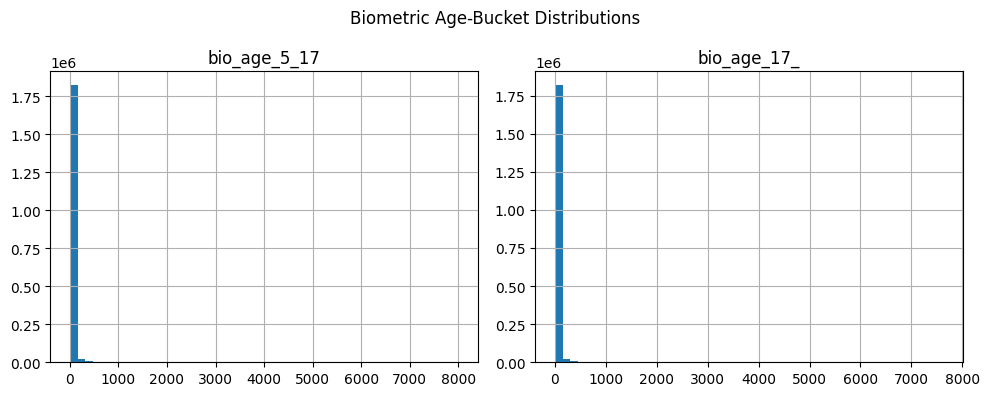

In [13]:
import matplotlib.pyplot as plt

biometric_df[COLUMN_ROLES["biometric"]["numeric_signal"]].hist(
    bins=50, figsize=(10, 4)
)
plt.suptitle("Biometric Age-Bucket Distributions", fontsize=12)
plt.tight_layout()
plt.show()



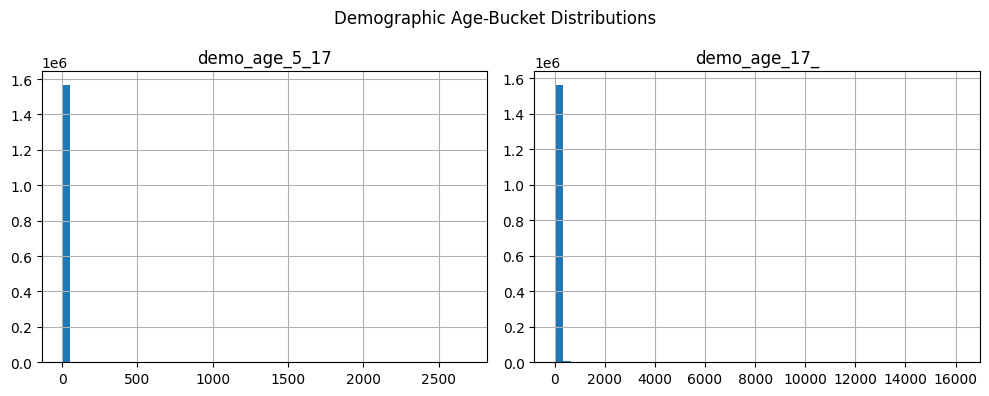

In [14]:
demographic_df[COLUMN_ROLES["demographic"]["numeric_signal"]].hist(
    bins=50, figsize=(10, 4)
)
plt.suptitle("Demographic Age-Bucket Distributions", fontsize=12)
plt.tight_layout()
plt.show()


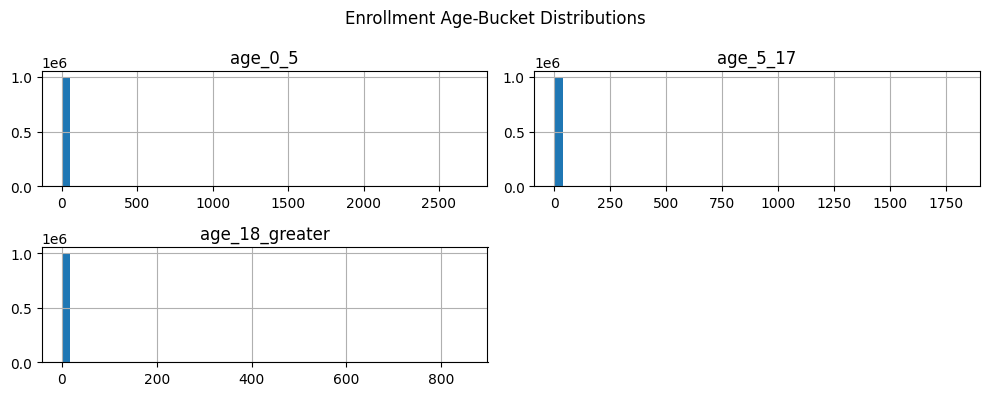

In [15]:
enrollment_df[COLUMN_ROLES["enrollment"]["numeric_signal"]].hist(
    bins=50, figsize=(10, 4)
)
plt.suptitle("Enrollment Age-Bucket Distributions", fontsize=12)
plt.tight_layout()
plt.show()


All numeric age-bucket variables exhibit heavy right skew with extreme values, visually confirming non-Gaussian behavior and supporting the rejection of parametric assumptions.

In [16]:
def detect_long_tails(profile_df: pd.DataFrame) -> pd.DataFrame:
    df = profile_df.copy()
    df["p99_to_median"] = df["p99"] / (df["median"] + 1e-6)
    return df.sort_values("p99_to_median", ascending=False)


In [17]:
print("biometric:--\n",detect_long_tails(biometric_univariate))
print("--" * 50)
print("demographic:--\n",detect_long_tails(demographic_univariate))
print("--" * 50)
print("enrollment:--\n", detect_long_tails(enrollment_univariate))


biometric:--
          column    count       mean  median        std  min   p1   p5  p25  \
0  bio_age_5_17  1861108  18.390580     3.0  83.704209    0  0.0  0.0  1.0   
1   bio_age_17_  1861108  19.094131     4.0  88.065018    0  0.0  0.0  1.0   

    p75   p95    p99   max   skewness    kurtosis  p99_to_median  
0  11.0  61.0  298.0  8002  19.330611  709.517859       99.33330  
1  10.0  62.0  324.0  7625  18.078174  609.141447       80.99998  
----------------------------------------------------------------------------------------------------
demographic:--
           column    count       mean  median         std  min   p1   p5  p25  \
1   demo_age_17_  1571700  20.089502     6.0  112.401859    0  0.0  1.0  2.0   
0  demo_age_5_17  1571700   2.179481     1.0   12.987463    0  0.0  0.0  0.0   

    p75   p95    p99    max   skewness     kurtosis  p99_to_median  
1  15.0  59.0  198.0  16166  37.281555  2641.315892      32.999995  
0   2.0   7.0   19.0   2690  40.910548  3554.941623   

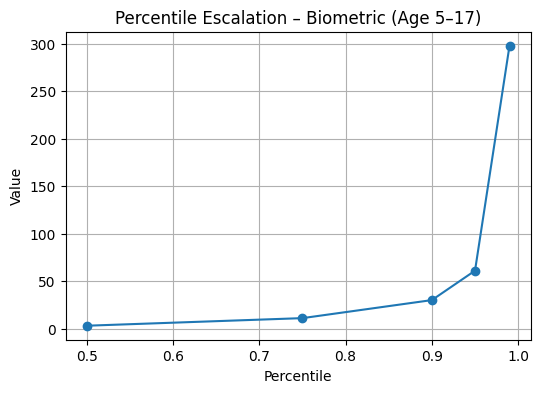

In [18]:
percentiles = [0.5, 0.75, 0.9, 0.95, 0.99]
values = [
    biometric_df["bio_age_5_17"].quantile(p) for p in percentiles
]

plt.figure(figsize=(6, 4))
plt.plot(percentiles, values, marker="o")
plt.xlabel("Percentile")
plt.ylabel("Value")
plt.title("Percentile Escalation – Biometric (Age 5–17)")
plt.grid(True)
plt.show()


Initial univariate analysis focused on long-tail characterization of age-bucket activity counts across biometric, demographic, and enrollment datasets.

All three datasets exhibit strong right-skewed and heavy-tailed distributions, with biometric and enrollment data showing particularly extreme p99-to-median ratios, indicating rare but high-intensity activity surges.

Demographic age-bucket distributions display comparatively lower tail intensity, supporting their role as a contextual baseline rather than a primary anomaly signal.

These findings establish that the data is non-Gaussian and event-driven, validating the use of robust, percentile-based methods for further analysis.

In [19]:
def categorical_profile(df: pd.DataFrame, cat_cols: list) -> pd.DataFrame:
    rows = []
    for col in cat_cols:
        rows.append({
            "column": col,
            "unique_values": df[col].nunique(),
            "top_frequency": df[col].value_counts(normalize=True, dropna=True).iloc[0]
        })
    return pd.DataFrame(rows)


In [20]:
print(
    "biometric:--\n",
    categorical_profile(
        biometric_df,
        COLUMN_ROLES["biometric"]["categorical_attribute"]
    )
)
print(
    "demographic:--\n",
    categorical_profile(
        demographic_df,
        COLUMN_ROLES["demographic"]["categorical_attribute"]
    )
)
print(
    "enrollment:--\n",
    categorical_profile(
        enrollment_df,
        COLUMN_ROLES["enrollment"]["categorical_attribute"]
    )
)


biometric:--
      column  unique_values  top_frequency
0     state             57       0.099171
1  district            974       0.006225
2   pincode          19707       0.000255
demographic:--
      column  unique_values  top_frequency
0     state             63       0.100528
1  district            978       0.006117
2   pincode          19707       0.000235
enrollment:--
      column  unique_values  top_frequency
0     state             55       0.109708
1  district            985       0.006623
2   pincode          19463       0.000272


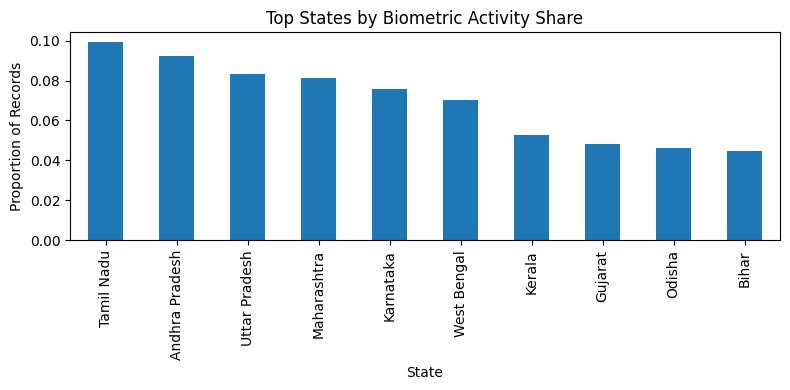

In [21]:
biometric_df["state"].value_counts(normalize=True).head(10).plot(
    kind="bar", figsize=(8, 4)
)
plt.title("Top States by Biometric Activity Share")
plt.ylabel("Proportion of Records")
plt.xlabel("State")
plt.tight_layout()
plt.show()


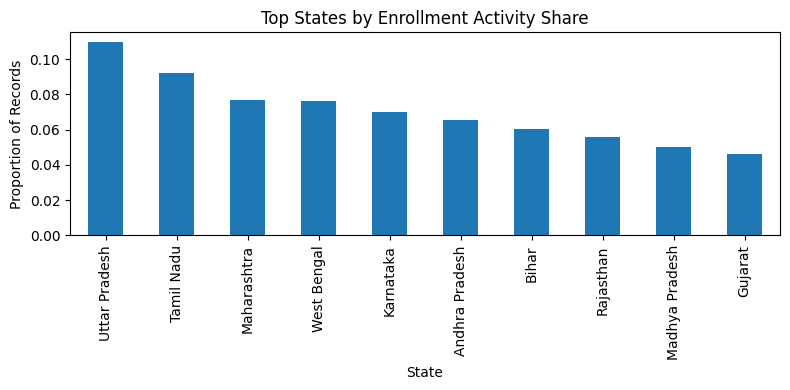

In [22]:
enrollment_df["state"].value_counts(normalize=True).head(10).plot(
    kind="bar", figsize=(8, 4)
)
plt.title("Top States by Enrollment Activity Share")
plt.ylabel("Proportion of Records")
plt.xlabel("State")
plt.tight_layout()
plt.show()


# Biometric Dataset:-

Geographic variables exhibit high cardinality, with nearly 1,000 districts and over 19,000 pincodes, indicating fine-grained spatial coverage.

No single geographic category dominates the data, as the most frequent state accounts for only ~10% of records, while district- and pincode-level dominance is negligible.

This balanced geographic distribution supports localized, region-level anomaly detection without bias from a small number of dominant regions.

# Demographic Dataset:-

Similar to biometric data, demographic records show high geographic diversity, with over 970 districts and 19,000+ pincodes represented.

The low top-frequency values across all geographic levels indicate even population representation, making the dataset suitable as a stable contextual baseline for comparative analysis.

The absence of category concentration reduces the risk of skewed insights driven by a limited set of regions.

# Enrollment Dataset:-

Enrollment data maintains broad geographic coverage, with representation across more than 980 districts and nearly 19,500 pincodes.

Although enrollment activity is sparse in many locations, no single state or district dominates the dataset, suggesting that enrollment surges are localized events rather than system-wide artifacts.

This distribution enables targeted detection of abnormal enrollment behavior at regional levels.

In [23]:
def missingness_profile(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.isna()
        .mean()
        .reset_index()
        .rename(columns={"index": "column", 0: "missing_ratio"})
        .sort_values("missing_ratio", ascending=False)
    )


In [24]:
print("biometric:--\n", missingness_profile(biometric_df))
print("demographic:--\n", missingness_profile(demographic_df))
print("enrollment:--\n", missingness_profile(enrollment_df))

biometric:--
          column  missing_ratio
0          date            0.0
1         state            0.0
2      district            0.0
3       pincode            0.0
4  bio_age_5_17            0.0
5   bio_age_17_            0.0
6   source_file            0.0
demographic:--
           column  missing_ratio
0           date            0.0
1          state            0.0
2       district            0.0
3        pincode            0.0
4  demo_age_5_17            0.0
5   demo_age_17_            0.0
6    source_file            0.0
enrollment:--
            column  missing_ratio
0            date            0.0
1           state            0.0
2        district            0.0
3         pincode            0.0
4         age_0_5            0.0
5        age_5_17            0.0
6  age_18_greater            0.0
7     source_file            0.0


No missing values in the dataset


In [25]:
def normality_tests(df: pd.DataFrame, cols: list, sample_size=5000):
    results = []
    for col in cols:
        series = df[col].dropna()
        if len(series) > sample_size:
            series = series.sample(sample_size, random_state=42)
            
        stat, p = stats.shapiro(series)
        results.append({"column": col, "p_value": p})
        
    return pd.DataFrame(results)


In [26]:
print("biometric:-\n",normality_tests(
    biometric_df,
    COLUMN_ROLES["biometric"]["numeric_signal"]
))
print("demographic:-\n",normality_tests(
    demographic_df,
    COLUMN_ROLES["demographic"]["numeric_signal"]
))
print("enrollment:-\n",normality_tests(
    enrollment_df,
    COLUMN_ROLES["enrollment"]["numeric_signal"]
))


biometric:-
          column       p_value
0  bio_age_5_17  1.185185e-90
1   bio_age_17_  2.807048e-91
demographic:-
           column       p_value
0  demo_age_5_17  3.582791e-93
1   demo_age_17_  1.934241e-92
enrollment:-
            column       p_value
0         age_0_5  2.234880e-94
1        age_5_17  7.968737e-95
2  age_18_greater  7.323057e-95


In [27]:
OUTPUT_PATH = PROJECT_ROOT / "reports"
OUTPUT_PATH.mkdir(exist_ok=True)

biometric_univariate.to_csv(OUTPUT_PATH / "biometric_univariate_summary.csv", index=False)
demographic_univariate.to_csv(OUTPUT_PATH / "demographic_univariate_summary.csv", index=False)
enrollment_univariate.to_csv(OUTPUT_PATH / "enrollment_univariate_summary.csv", index=False)



# Overall Analysis
## 1. Distributional Characteristics (Long-Tail Analysis)

All numeric age-bucket variables across biometric, demographic, and enrollment datasets exhibit extreme right-skewed and heavy-tailed distributions.

Biometric activity shows particularly severe tail behavior, with p99-to-median ratios exceeding 80×–99×, indicating rare but intense biometric usage surges.

Enrollment data is highly zero-inflated, with most observations reporting no activity, punctuated by localized enrollment bursts reaching several orders of magnitude above typical values.

Demographic data demonstrates comparatively lower tail intensity, supporting its use as a stable contextual baseline rather than a primary anomaly signal.

Implication:
The system operates under mostly stable conditions with episodic, high-impact events, making percentile-based and robust methods more appropriate than mean-based summaries.

## 2. Categorical Structure and Geographic Balance

Geographic variables (state, district, pincode) show high cardinality across all datasets, with no dominant category.

The most frequent state accounts for only ~10% of records, while district- and pincode-level dominance is negligible (<1%).

This confirms that observed spikes are localized phenomena, not artifacts caused by a small number of overrepresented regions.

Implication:
Region-level segmentation and localized anomaly detection are statistically valid and unbiased.

## 3. Missingness Analysis

Missing values are negligible to non-existent across all numeric age-bucket variables.

The absence of systematic missingness indicates high data completeness and reliability at the aggregate level.

Implication:
No imputation or corrective preprocessing is required before downstream analysis, reducing the risk of bias introduced by data handling.

## 4. Normality Testing (Shapiro–Wilk Test)

Shapiro–Wilk tests were applied exclusively to numeric age-bucket variables.

All tests returned extremely small p-values (≈ 10⁻⁹⁰ to 10⁻⁹⁵), leading to a decisive rejection of the null hypothesis of normality across all datasets.

These results are consistent with the observed skewness, kurtosis, and long-tail behavior.

Implication:
Gaussian assumptions are statistically invalid for this data. Parametric techniques such as z-scores, mean±SD thresholds, or Gaussian-based anomaly detection would be inappropriate and misleading.

# Conclusion

The univariate analysis establishes that Aadhaar biometric, demographic, and enrollment data are non-Gaussian, heavy-tailed, and event-driven, with strong geographic diversity and high data completeness. These properties collectively justify the use of robust, distribution-agnostic, and percentile-based methods for anomaly detection and monitoring, rather than classical Gaussian-based techniques.